# Note

We visualise the graphs y,x as we had them the wrong way round initially - but doesn't as is symmetric problem therefore just flip for the visualisation 

## Analysis notebook

### Imports

In [2]:
from bokeh.plotting import output_file, save
import json
import os
import pickle
from locpix_points.data_loading import datastruc
from locpix_points.scripts.visualise import visualise_torch_geometric, visualise_parquet, load_file
from locpix_points.scripts.featanalyse import (
    generate_umap_embedding,
    visualise_umap_embedding,
    generate_pca_embedding,
    visualise_pca_embedding,
    visualise_explanation,
    k_means_fn,
    get_prediction,
    subgraph_eval,
    pgex_eval,
    attention_eval,
)

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import polars as pl
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import torch
import umap
import yaml

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/root/micromamba/envs/locpix-points/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:21: UserWarning: You are using pyarrow version 13.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/root/micromamba/envs/locpix-points/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### Functions

In [4]:
def find_graph_path(project_directory, file_name, file_folder):
    """Visualise raw data
    
    Args:
        project_directory (string): Location of project directory
        file_name (string) : Name of file to image
        file_folder (string) : Which folder the file is in"""
    
    train_file_map_path = os.path.join(project_directory, f"{file_folder}/train/file_map.csv")
    val_file_map_path = os.path.join(project_directory, f"{file_folder}/val/file_map.csv")
    test_file_map_path = os.path.join(project_directory, f"{file_folder}/test/file_map.csv")
    
    train_file_map = pd.read_csv(train_file_map_path)
    val_file_map = pd.read_csv(val_file_map_path)
    test_file_map = pd.read_csv(test_file_map_path)
    
    train_out = train_file_map[train_file_map["file_name"] == file_name]
    val_out = val_file_map[val_file_map["file_name"] == file_name]
    test_out = test_file_map[test_file_map["file_name"] == file_name]
    
    if len(train_out) > 0:
        folder = "train"
        file_name = train_out["idx"].values[0]
    if len(val_out) > 0:
        folder = "val"
        file_name = val_out["idx"].values[0]
    if len(test_out) > 0:
        folder = "test"
        file_name = test_out["idx"].values[0]
    
    return os.path.join(project_directory, f"{file_folder}/{folder}/{file_name}.pt")

### Parameters

In [3]:
project_directory = ".."
# load config
with open(os.path.join(project_directory, "config/featanalyse_manual.yaml"), "r") as ymlfile:
    config_manual = yaml.safe_load(ymlfile)
with open(os.path.join(project_directory, "config/featanalyse_nn.yaml"), "r") as ymlfile:
    config_nn = yaml.safe_load(ymlfile)
label_map = config_manual["label_map"]
assert label_map == config_nn["label_map"]
manual_features = config_manual["features"]

In [6]:
final_test = True
umap_n_neighbours = 20
umap_min_dist = 0.5
pca_n_components = 2
device = 'cuda'

### Analyse the manual features

In [7]:
train_df = os.path.join(project_directory, "output/train_df_manual.csv")
train_df = pl.read_csv(train_df)
train_df_pd = train_df.to_pandas()

if final_test:
    test_df = os.path.join(project_directory, "output/test_df_manual.csv")
    test_df = pl.read_csv(test_df)
    test_df_pd = test_df.to_pandas()

#### Compare PCA vs Convex hull

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
sns.scatterplot(data=train_df_pd, x = "length_pca", y="length_convex_hull",s=5, ax=ax1)
sns.scatterplot(data=train_df_pd, x = "area_pca", y="area_convex_hull",s=5, ax=ax2)
plt.show()

if final_test:
    print("Final test")
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
    sns.scatterplot(data=test_df_pd, x = "length_pca", y="length_convex_hull",s=5, ax=ax1)
    sns.scatterplot(data=test_df_pd, x = "area_pca", y="area_convex_hull",s=5, ax=ax2)
    plt.show()

#### Cluster features boxplots

In [ ]:
# number of clusters per FOV, cluster type, ...
train_cluster_counts = train_df["file_name"].value_counts()
print("Number of clusters per FOV:", train_cluster_counts)
# number of clusters in each class
train_type_counts = train_df["type"].value_counts()
print("Number of clusters in each class:", train_type_counts)

# per fov features grouped by mean with std
train_df_boxplot = train_df[manual_features + ["type", "file_name"]].to_pandas()

fig, axs = plt.subplots(2,4, figsize=(20,8))
assert len(manual_features) == 8
counter = 0
for feat in manual_features:
    sns.boxplot(x='type', y=feat, data=train_df_boxplot, color='k', fill=False, flierprops=dict(marker='x', markersize=5), ax=axs[counter//4][counter%4])
    counter += 1
plt.show()


if final_test:
    print("Final test")
    # number of clusters per FOV, cluster type, ...
    test_cluster_counts = test_df["file_name"].value_counts()
    print("Number of clusters per FOV:", test_cluster_counts)
    # number of clusters in each class
    test_type_counts = test_df["type"].value_counts()
    print("Number of clusters in each class:", test_type_counts)

    # per fov features grouped by mean with std
    test_df_boxplot = test_df[manual_features + ["type", "file_name"]].to_pandas()

    fig, axs = plt.subplots(2,4, figsize=(20,8))
    assert len(manual_features) == 8
    counter = 0
    for feat in manual_features:
        sns.boxplot(x='type', y=feat, data=test_df_boxplot, color='k', fill=False, flierprops=dict(marker='x', markersize=5), ax=axs[counter//4][counter%4])
        counter += 1
    plt.show()
#

### Graph feature explainability

In [5]:
# get features present in the dataframe
not_features = ["clusterID", "x_mean", "y_mean", "type", "file_name"]
features = [x for x in train_df.columns if x not in not_features]

# now remove features not selected by user
removed_features = [f for f in features if f not in manual_features]
print("Removed features: ", removed_features)
features = [f for f in features if f in manual_features]
print("Features analysed: ", features)

# feature vector
train_data_feats = train_df_pd[features].values
if final_test:
    test_data_feats = test_df_pd[features].values

num_features = len(train_data_feats[0])
print("Num features: ", num_features)
############ WARNING ##############
# Be careful, if analysing neural net features
# Is this the number of features you expect
# Did this task use manual features as well

scaler = StandardScaler().fit(train_data_feats)
X_train = scaler.transform(train_data_feats)
if final_test:
    X_test = scaler.transform(test_data_feats)

NameError: name 'train_df' is not defined

#### UMAP

In [ ]:
train_umap_embedding_manual_path = os.path.join(project_directory, "output/train_umap_embedding_manual.pkl")
test_umap_embedding_manual_path = os.path.join(project_directory, "output/test_umap_embedding_manual.pkl")

#if not os.path.exists(train_umap_embedding_manual_path):
#    train_umap_embedding = generate_umap_embedding(X_train, umap_min_dist, umap_n_neighbours)
#    with open(train_umap_embedding_manual_path, "wb") as f:
#        pickle.dump(train_umap_embedding, f)
#    f.close()

if final_test:
    print("Final test")
    if not os.path.exists(test_umap_embedding_manual_path):
        test_umap_embedding = generate_umap_embedding(X_test, umap_min_dist, umap_n_neighbours)
        with open(test_umap_embedding_manual_path, "wb") as f:
            pickle.dump(test_umap_embedding, f)
        f.close()

In [ ]:
%matplotlib widget
#with open(train_umap_embedding_manual_path, "rb") as f:
#    train_umap_embedding = pickle.load(f)
#visualise_umap_embedding(train_umap_embedding, train_df_pd, label_map)
if final_test:
    with open(test_umap_embedding_manual_path, "rb") as f:
        test_umap_embedding = pickle.load(f)
    visualise_umap_embedding(test_umap_embedding, test_df_pd, label_map, save=False, save_name="manual_umap_nn_20_mindist_0.5", project_directory=project_directory, point_size=0.001)

#### PCA

In [ ]:
train_pca_embedding = generate_pca_embedding(X_train, pca_n_components)
if final_test:
    test_pca_embedding = generate_pca_embedding(X_test, pca_n_components)


In [ ]:
visualise_pca_embedding(train_pca_embedding, train_df_pd, label_map)
if final_test:
    visualise_pca_embedding(test_pca_embedding, test_df_pd, label_map)

#### K-means

In [ ]:
k_means_fn(X_train, train_df_pd, label_map)
if final_test:
    k_means_fn(X_test, test_df_pd, label_map)

## Analyse the nn features

In [8]:
train_df_nn_loc = os.path.join(project_directory, "output/train_df_nn_loc.csv")
train_df_nn_loc = pd.read_csv(train_df_nn_loc)

train_df_nn_cluster = os.path.join(project_directory, "output/train_df_nn_cluster.csv")
train_df_nn_cluster = pd.read_csv(train_df_nn_cluster)

train_df_nn_fov = os.path.join(project_directory, "output/train_df_nn_fov.csv")
train_df_nn_fov = pd.read_csv(train_df_nn_fov)

if final_test:  
    test_df_nn_loc = os.path.join(project_directory, "output/test_df_nn_loc.csv")
    test_df_nn_loc = pd.read_csv(test_df_nn_loc)

    test_df_nn_cluster = os.path.join(project_directory, "output/test_df_nn_cluster.csv")
    test_df_nn_cluster = pd.read_csv(test_df_nn_cluster)

    test_df_nn_fov = os.path.join(project_directory, "output/test_df_nn_fov.csv")
    test_df_nn_fov = pd.read_csv(test_df_nn_fov)

else:
    test_df_nn_loc = None
    test_df_nn_cluster = None
    test_df_nn_fov = None


### Graph feature explainability

In [9]:
def prep_features(train_df, test_df):

    # get features present in the dataframe
    not_features = ["type", "file_name"]
    features = [x for x in train_df.columns.to_list() if x not in not_features]

    # feature vector
    train_data_feats_nn = train_df[features].values
    if final_test:
        test_data_feats_nn = test_df[features].values

    num_features = len(train_data_feats_nn[0])
    print("Num features: ", num_features)
    ############ WARNING ##############
    # Be careful, if analysing neural net features
    # Is this the number of features you expect
    # Did this task use manual features as well

    scaler = StandardScaler().fit(train_data_feats_nn)
    X_train_nn = scaler.transform(train_data_feats_nn)
    if final_test:
        X_test_nn = scaler.transform(test_data_feats_nn)
        
        return X_train_nn, X_test_nn
    else:
        return X_train_nn, None

X_train_nn_loc, X_test_nn_loc = prep_features(train_df_nn_loc, test_df_nn_loc)
X_train_nn_cluster, X_test_nn_cluster = prep_features(train_df_nn_cluster, test_df_nn_cluster)
X_train_nn_fov, X_test_nn_fov = prep_features(train_df_nn_fov, test_df_nn_fov)

Num features:  8
Num features:  40
Num features:  40


#### UMAP

In [10]:
train_umap_embedding_nn_loc_path = os.path.join(project_directory, "output/train_umap_embedding_nn_loc.pkl")
train_umap_embedding_nn_cluster_path = os.path.join(project_directory, "output/train_umap_embedding_nn_cluster.pkl")
train_umap_embedding_nn_fov_path = os.path.join(project_directory, "output/train_umap_embedding_nn_fov.pkl")

test_umap_embedding_nn_loc_path = os.path.join(project_directory, "output/test_umap_embedding_nn_loc.pkl")
test_umap_embedding_nn_cluster_path = os.path.join(project_directory, "output/test_umap_embedding_nn_cluster.pkl")
test_umap_embedding_nn_fov_path = os.path.join(project_directory, "output/test_umap_embedding_nn_fov.pkl")

#if not os.path.exists(train_umap_embedding_nn_loc_path):
#    train_umap_embedding_nn_loc = generate_umap_embedding(X_train_nn_loc, umap_min_dist, umap_n_neighbours)
#    with open(train_umap_embedding_nn_loc_path, "wb") as f:
#        pickle.dump(train_umap_embedding_nn_loc, f)
#    f.close()
#if not os.path.exists(train_umap_embedding_nn_cluster_path):
#    train_umap_embedding_nn_cluster = generate_umap_embedding(X_train_nn_cluster, umap_min_dist, umap_n_neighbours)
#    with open(train_umap_embedding_nn_cluster_path, "wb") as f:
#        pickle.dump(train_umap_embedding_nn_cluster, f)
#    f.close()
#if not os.path.exists(train_umap_embedding_nn_fov_path):
#    train_umap_embedding_nn_fov = generate_umap_embedding(X_train_nn_fov, umap_min_dist, umap_n_neighbours)
#    with open(train_umap_embedding_nn_fov_path, "wb") as f:
#        pickle.dump(train_umap_embedding_nn_fov, f)
#    f.close()
if final_test:
    if not os.path.exists(test_umap_embedding_nn_loc_path):
        test_umap_embedding_nn_loc = generate_umap_embedding(X_test_nn_loc, umap_min_dist, umap_n_neighbours)
        with open(test_umap_embedding_nn_loc_path, "wb") as f:
            pickle.dump(test_umap_embedding_nn_loc, f)
        f.close()
    
    if not os.path.exists(test_umap_embedding_nn_cluster_path):
        test_umap_embedding_nn_cluster = generate_umap_embedding(X_test_nn_cluster, umap_min_dist, umap_n_neighbours)
        with open(test_umap_embedding_nn_cluster_path, "wb") as f:
            pickle.dump(test_umap_embedding_nn_cluster, f)
        f.close()

    if not os.path.exists(test_umap_embedding_nn_fov_path):
        test_umap_embedding_nn_fov = generate_umap_embedding(X_test_nn_fov, umap_min_dist, umap_n_neighbours)
        with open(test_umap_embedding_nn_fov_path, "wb") as f:
            pickle.dump(test_umap_embedding_nn_fov, f)
        f.close()

In [ ]:
print("------ LOC ENCODER -------")
#with open(train_umap_embedding_nn_loc_path, "rb") as f:
#        train_umap_embedding_nn_loc = pickle.load(f)
#visualise_umap_embedding(train_umap_embedding_nn_loc, train_df_nn_loc, label_map)
if final_test:
    with open(test_umap_embedding_nn_loc_path, "rb") as f:
        test_umap_embedding_nn_loc = pickle.load(f)
    visualise_umap_embedding(test_umap_embedding_nn_loc, test_df_nn_loc, label_map, save=False, save_name="nn_loc_encoder_umap_nn_20_mindist_0.5", project_directory=project_directory, point_size=0.001)


In [ ]:
print("------ CLUSTER ENCODER -------")
#with open(train_umap_embedding_nn_cluster_path, "rb") as f:
#        train_umap_embedding_nn_cluster = pickle.load(f)
#visualise_umap_embedding(train_umap_embedding_nn_cluster, train_df_nn_cluster, label_map)
if final_test:
    with open(test_umap_embedding_nn_cluster_path, "rb") as f:
            test_umap_embedding_nn_cluster = pickle.load(f)
    visualise_umap_embedding(test_umap_embedding_nn_cluster, test_df_nn_cluster, label_map, save=False, save_name="nn_cluster_encoder_umap_nn_20_mindist_0.5", project_directory=project_directory, point_size=0.001)

In [11]:
print("------ FOV ENCODER -------")
#with open(train_umap_embedding_nn_fov_path, "rb") as f:
#        train_umap_embedding_nn_fov = pickle.load(f)
#visualise_umap_embedding(train_umap_embedding_nn_fov, train_df_nn_fov, label_map)
if final_test:
    with open(test_umap_embedding_nn_fov_path, "rb") as f:
        test_umap_embedding_nn_fov = pickle.load(f)
    plot = visualise_umap_embedding(test_umap_embedding_nn_fov, 
                             test_df_nn_fov, 
                             label_map, 
                             save=False, 
                             save_name="nn_fov_encoder_umap_nn_20_mindist_0.5", 
                             project_directory=project_directory,
                             interactive=True, 
                             point_size=5)
    if True:
        output_file_loc  = os.path.join(project_directory, "output", "nn_fov.html")
        output_file(output_file_loc)
        save(plot)

------ FOV ENCODER -------


Loading BokehJS ...

#### PCA

In [ ]:
train_pca_embedding_nn_loc = generate_pca_embedding(X_train_nn_loc, pca_n_components)
train_pca_embedding_nn_fov = generate_pca_embedding(X_train_nn_fov, pca_n_components)
train_pca_embedding_nn_cluster = generate_pca_embedding(X_train_nn_cluster, pca_n_components)
if final_test:
    test_pca_embedding_nn_loc = generate_pca_embedding(X_test_nn_loc, pca_n_components)
    test_pca_embedding_nn_fov = generate_pca_embedding(X_test_nn_fov, pca_n_components)
    test_pca_embedding_nn_cluster = generate_pca_embedding(X_test_nn_cluster, pca_n_components)

In [ ]:
print("------ LOC ENCODER -------")
visualise_pca_embedding(train_pca_embedding_nn_loc, train_df_nn_loc, label_map)
if final_test:
    visualise_pca_embedding(test_pca_embedding_nn_loc, test_df_nn_loc, label_map)

In [ ]:
print("------ CLUSTER ENCODER -------")
visualise_pca_embedding(train_pca_embedding_nn_cluster, train_df_nn_cluster, label_map)
if final_test:
    visualise_pca_embedding(test_pca_embedding_nn_cluster, test_df_nn_cluster, label_map)


In [ ]:
print("------ FOV ENCODER -------")
visualise_pca_embedding(train_pca_embedding_nn_fov, train_df_nn_fov, label_map)
if final_test:
    visualise_pca_embedding(test_pca_embedding_nn_fov, test_df_nn_fov, label_map)

#### K-means

In [ ]:
print("----- LOC ------")
k_means_fn(X_train_nn_loc, train_df_nn_loc, label_map)
if final_test:
    k_means_fn(X_test_nn_loc, test_df_nn_loc, label_map)

print("----- CLUSTER ------")
k_means_fn(X_train_nn_cluster, train_df_nn_cluster, label_map)
if final_test:
    k_means_fn(X_test_nn_cluster, test_df_nn_cluster, label_map)

print("----- FOV ------")
k_means_fn(X_train_nn_fov, train_df_nn_fov, label_map)
if final_test:
    k_means_fn(X_test_nn_fov, test_df_nn_fov, label_map)


### Graph structure explainability

In [7]:
# get item to evaluate on
file_name = "L_542" #"grid_2056"

#### Load in configuration

In [17]:
config_path = os.path.join(project_directory, "config/featanalyse_nn.yaml")
with open(config_path, "r") as ymlfile:
    config = yaml.safe_load(ymlfile)

# load in gt_label_map
metadata_path = os.path.join(project_directory, "metadata.json")
with open(
    metadata_path,
) as file:
    metadata = json.load(file)
    # add time ran this script to metadata
    gt_label_map = metadata["gt_label_map"]

gt_label_map = {int(key): val for key, val in gt_label_map.items()}

#### Visualise raw file

In [ ]:
if not final_test:
    file_folder = "preprocessed/gt_label"
else:
    file_folder = "preprocessed/test/gt_label"
file_path = os.path.join(project_directory, file_folder, file_name + ".parquet")
visualise_parquet(file_path, 'x', 'y', None, 'channel', {0: "channel_0", 1: "channel_1", 2: "channel_2", 3: "channel_3"}, cmap=['k'], spheres=True, sphere_size=0.004)

#### Visualise graph

In [ ]:
if not final_test:
    fold = config["fold"]
    file_folder = f"processed/fold_{fold}"
else:
    file_folder = "processed"
file_loc = find_graph_path(project_directory, file_name, file_folder)
visualise_torch_geometric(file_loc)

#### Load in cluster model

In [14]:
cluster_model = torch.load(os.path.join(project_directory, f"output/cluster_model.pt"))
cluster_model.to(device)
cluster_model.eval()

ClusterNetHomogeneous(
  (cluster_encoder_0): PointNetConv(local_nn=MLP(10, 12, 14), global_nn=MLP(14, 16, 16))
  (cluster_encoder_1): PointNetConv(local_nn=MLP(18, 20, 22), global_nn=MLP(22, 24, 24))
  (cluster_encoder_2): PointNetConv(local_nn=MLP(26, 28, 30), global_nn=MLP(30, 32, 32))
  (cluster_encoder_3): PointNetConv(local_nn=MLP(34, 36, 38), global_nn=MLP(38, 40, 40))
  (linear): Linear(in_features=40, out_features=7, bias=True)
  (pool): MaxAggregation()
)

#### Load datasets

In [15]:
cluster_train_folder = os.path.join(project_directory, "processed/featanalysis/train")
cluster_val_folder = os.path.join(project_directory, "processed/featanalysis/val")
cluster_test_folder = os.path.join(project_directory, "processed/featanalysis/test")

if not final_test:
    loc_test_folder = os.path.join(
        project_directory, "processed", f"fold_{fold}", "test"
    )
    loc_train_folder = os.path.join(
        project_directory, "processed", f"fold_{fold}", "train"
    )
    loc_val_folder = os.path.join(
        project_directory, "processed", f"fold_{fold}", "val"
    )

else:
    loc_test_folder = os.path.join(project_directory, "processed", "test")
    loc_train_folder = os.path.join(project_directory, "processed", "train")
    loc_val_folder = os.path.join(project_directory, "processed", "val")


cluster_train_set = datastruc.ClusterDataset(
    None,
    cluster_train_folder,
    label_level=None,
    pre_filter=None,
    save_on_gpu=None,
    transform=None,
    pre_transform=None,
    fov_x=None,
    fov_y=None,
)

cluster_val_set = datastruc.ClusterDataset(
    None,
    cluster_val_folder,
    label_level=None,
    pre_filter=None,
    save_on_gpu=None,
    transform=None,
    pre_transform=None,
    fov_x=None,
    fov_y=None,
)

cluster_test_set = datastruc.ClusterDataset(
    None,
    cluster_test_folder,
    label_level=None,
    pre_filter=None,
    save_on_gpu=None,
    transform=None,
    pre_transform=None,
    fov_x=None,
    fov_y=None,
)

# localisations are yet to be passed through any network

loc_train_set = datastruc.ClusterLocDataset(
    None,  # raw_loc_dir_root
    None,  # raw_cluster_dir_root
    loc_train_folder,  # processed_dir_root
    label_level=None,
    pre_filter=None,
    save_on_gpu=None,
    transform=None,
    pre_transform=None,
    loc_feat=None,
    cluster_feat=None,
    min_feat_locs=None,
    max_feat_locs=None,
    min_feat_clusters=None,
    max_feat_clusters=None,
    kneighboursclusters=None,
    fov_x=None,
    fov_y=None,
    kneighbourslocs=None,
)

loc_val_set = datastruc.ClusterLocDataset(
    None,  # raw_loc_dir_root
    None,  # raw_cluster_dir_root
    loc_val_folder,  # processed_dir_root
    label_level=None,
    pre_filter=None,
    save_on_gpu=None,
    transform=None,
    pre_transform=None,
    loc_feat=None,
    cluster_feat=None,
    min_feat_locs=None,
    max_feat_locs=None,
    min_feat_clusters=None,
    max_feat_clusters=None,
    kneighboursclusters=None,
    fov_x=None,
    fov_y=None,
    kneighbourslocs=None,
)

loc_test_set = datastruc.ClusterLocDataset(
    None,  # raw_loc_dir_root
    None,  # raw_cluster_dir_root
    loc_test_folder,  # processed_dir_root
    label_level=None,
    pre_filter=None,
    save_on_gpu=None,
    transform=None,
    pre_transform=None,
    loc_feat=None,
    cluster_feat=None,
    min_feat_locs=None,
    max_feat_locs=None,
    min_feat_clusters=None,
    max_feat_clusters=None,
    kneighboursclusters=None,
    fov_x=None,
    fov_y=None,
    kneighbourslocs=None,
)


/home/oliver/smlm_cloud/others/pytorch_geometric/torch_geometric/data/dataset.py:222: UserWarning: The `pre_filter` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-fitering technique, make sure to delete '{self.processed_dir}' first
  warnings.warn(


#### Get items to evaluate on 

In [ ]:
cluster_dataitem, loc_dataitem, prediction = get_prediction(
    file_name,
    cluster_model, 
    cluster_train_set, 
    loc_train_set, 
    cluster_val_set, 
    loc_val_set, 
    cluster_test_set, 
    loc_test_set,
    project_directory,
    device, 
    gt_label_map
)

#### SubgraphX

In [10]:
subgraph_config = {
    # number of iterations to get prediction
    "rollout":  100,
    # number of atoms of leaf node in search tree
    "min_atoms": 5,
    # hyperparameter that encourages exploration
    "c_puct": 10.0,
    # number of atoms to expand when extend the child nodes in the search tree
    "expand_atoms": 14,
    # whether to expand the children nodes from high degreee to low degree when extend the child nodes in the search tree
    "high2low": False,
    # number of local radius to caclulate
    "local_radius": 4,
    # sampling time of montecarlo approxim
    "sample_num": 100,
    # reward method
    "reward_method": "mc_l_shapley",
    # subgrpah building method
    "subgraph_building_method": "split",
    # maximum number of nodes to include in subgraph when generating explanation
    "max_nodes": 8,
    # number of classes
    "num_classes": 7,
}

In [ ]:
 # ---- subgraphx -----
_, _, cluster_dataitem, node_imp = subgraph_eval(cluster_model, device, subgraph_config, cluster_dataitem, prediction)
    

In [ ]:
# visualise overlaid subgraph

if not final_test:
    fold = config["fold"]
    file_folder = f"processed/fold_{fold}"
else:
    file_folder = "processed"
file_loc = find_graph_path(project_directory, file_name, file_folder)

feat.visualise_explanation(
    cluster_dataitem.pos,
    cluster_dataitem.edge_index,
    node_imp=node_imp.to(device),
    edge_imp=None,
    overlay=True,
    file_loc=file_loc, 
)


#### PgEx

In [ ]:
pgex_config = {
    # threshold to apply to edge mask for pyg explain
    "edge_mask_threshold": 0.5,
}

In [ ]:
# ---- pgexplainer ----
pg_explainer = torch.load(os.path.join(project_directory, f"output/pg_explainer.pt")) 
pgex_eval(cluster_model, pg_explainer, cluster_dataitem, device, pgex_config)

### Identify incorrectly predicted points in the UMAP for the test

In [18]:
files = plot.renderers[0].data_source.data["file_name"]
files = [x.removesuffix('.parquet') for x in files]

wrong_files = []
for file in files:
    file_name = file
    x, _, pred = cluster_dataitem, loc_dataitem, prediction = get_prediction(
        file_name,
        cluster_model, 
        cluster_train_set, 
        loc_train_set, 
        cluster_val_set, 
        loc_val_set, 
        cluster_test_set, 
        loc_test_set,
        project_directory,
        device, 
        gt_label_map)
    if x.y.detach().item() != pred:
        wrong_files.append(x.name)

new_colors = ["#000000"]*len(files)
for id, file in enumerate(files):
    if file in wrong_files:
        new_colors[id] = "#FF0000"

-----
Predicted label:  L
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  T
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  T
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  L

In [19]:
plot.renderers[0].data_source.data["new_colors"] = new_colors
plot.renderers[0].glyph.fill_color = 'new_colors'
plot.renderers[0].glyph.line_color = 'new_colors'
umap.plot.show(plot)

Start : This command cannot be run due to the error: The system cannot find the file specified.
At line:1 char:1
+ Start "/home/oliver/smlm_cloud/locpix-points/digits_letters/task_1_fi ...
+ ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    + CategoryInfo          : InvalidOperation: (:) [Start-Process], InvalidOperationException
    + FullyQualifiedErrorId : InvalidOperationException,Microsoft.PowerShell.Commands.StartProcessCommand
 


### Statistical tests

In [30]:
# foo

### Publication figures

In [8]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from torch_geometric.utils.convert import to_networkx
import networkx as nx
from networkx.drawing import draw_networkx, draw
import numpy as np


In [9]:
files = ["three_757", "one_184", "two_2786", "L_542"]

#### Raw files

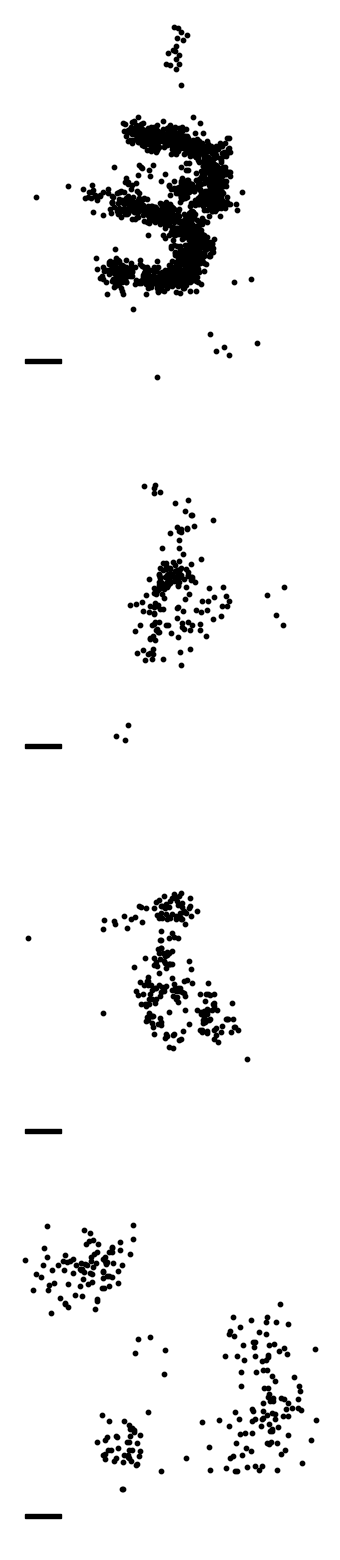

In [13]:
if not final_test:
    file_folder = "preprocessed/gt_label"
else:
    file_folder = "preprocessed/test/gt_label"
fig, ax = plt.subplots(4,1,figsize=(20,20), sharex=True, sharey=True)
for idx, file_name in enumerate(files):
    file_path = os.path.join(project_directory, file_folder, file_name + ".parquet")
    df, unique_chans = load_file(file_path, "x", "y", None, "channel")
    x = df["x"].to_numpy()
    y = df["y"].to_numpy()
    ax[idx].set_aspect('equal', adjustable='box')
    ax[idx].scatter(y, x, s=10, c='k')
    ax[idx].axis('off')
    scalebar = AnchoredSizeBar(ax[idx].transData,
                               0.1, '', 'lower left', 
                               pad=1,
                               color='k',
                               frameon=False,
                               size_vertical=0.01)

    ax[idx].add_artist(scalebar)
output_path = os.path.join(project_directory, "output", "combined" + '_raw_s_10.svg') 
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(output_path, transparent=True, bbox_inches="tight", pad_inches=0)

#### Clustering

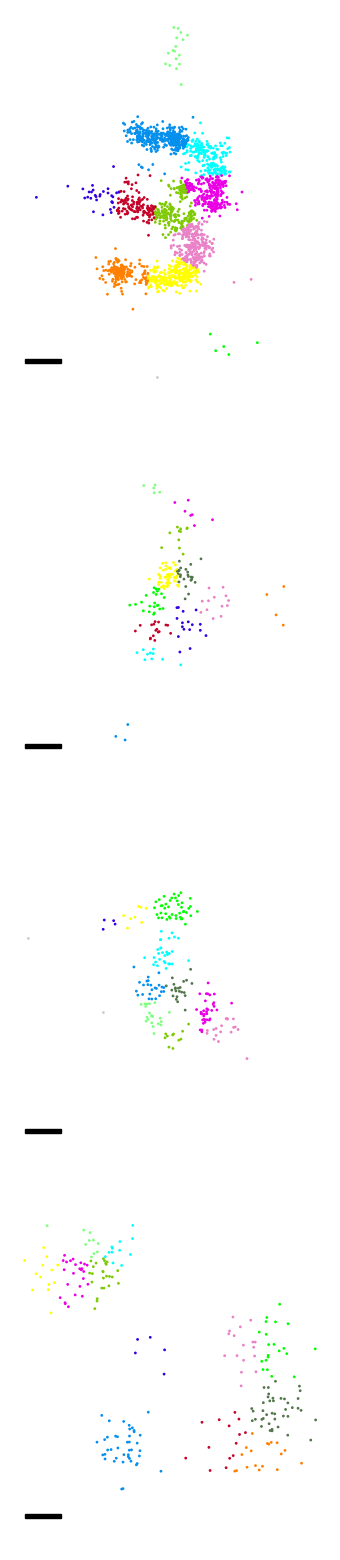

In [14]:
if not final_test:
    gt_file_folder = "preprocessed/gt_label"
    feat_file_folder = "preprocessed/featextract/locs"
else:
    gt_file_folder = "preprocessed/test/gt_label"
    feat_file_folder = "preprocessed/test/featextract/locs"

fig, ax = plt.subplots(4,1,figsize=(20,20), sharex=True, sharey=True)
colors_grey = ['0.8', (0.0, 1.0, 0.0), (0.9198330167772646, 0.00019544195496590255, 0.9023663764628042), (0.022826063681157582, 0.5658432009989469, 0.9292042754527637), (1.0, 0.5, 0.0), (0.2022271667963922, 0.004776515828955663, 0.892404204324589), (0.3303283202899151, 0.4608491026134133, 0.2941030733894585), (0.5, 1.0, 0.5), (0.7723074963983451, 0.0066115490293984225, 0.15243662980903372), (0.9136952591189091, 0.5104151769385785, 0.7797496184063708), (1.0, 1.0, 0.0), (0.0, 1.0, 1.0), (0.4996633088717094, 0.7906621743682507, 0.01563627319525085)]
cmap_grey = ListedColormap(colors_grey)
colors = [(0.0, 1.0, 0.0), (0.9198330167772646, 0.00019544195496590255, 0.9023663764628042), (0.022826063681157582, 0.5658432009989469, 0.9292042754527637), (1.0, 0.5, 0.0), (0.2022271667963922, 0.004776515828955663, 0.892404204324589), (0.3303283202899151, 0.4608491026134133, 0.2941030733894585), (0.5, 1.0, 0.5), (0.7723074963983451, 0.0066115490293984225, 0.15243662980903372), (0.9136952591189091, 0.5104151769385785, 0.7797496184063708), (1.0, 1.0, 0.0), (0.0, 1.0, 1.0), (0.4996633088717094, 0.7906621743682507, 0.01563627319525085)]
cmap_no_grey = ListedColormap(colors)

for idx, file_name in enumerate(files):
    file_path = os.path.join(project_directory, gt_file_folder, file_name + ".parquet")
    df_gt = pl.read_parquet(file_path)
    file_path = os.path.join(project_directory, feat_file_folder, file_name + ".parquet")
    df_feat = pl.read_parquet(file_path)
    df = df_feat.join(df_gt, on=["x", "y", "channel", "frame"], how = "outer")
    df = df.with_columns(pl.col("clusterID").fill_null(-1))
    assert df["channel"].unique().item() == 0
    x = df["x"].to_numpy()
    y = df["y"].to_numpy()
    c = df["clusterID"].to_numpy()
    if np.min(c) == -1:
        cmap = cmap_grey
    else:
        cmap = cmap_no_grey
    ax[idx].set_aspect('equal', adjustable='box')
    ax[idx].scatter(y, x, s=1, c=c, cmap=cmap)
    ax[idx].axis('off')
    scalebar = AnchoredSizeBar(ax[idx].transData,
                            0.1, '', 'lower left', 
                            pad=1,
                            color='k',
                            frameon=False,
                            size_vertical=0.01)

    ax[idx].add_artist(scalebar)
output_path = os.path.join(project_directory, "output", "combined" + '_clustered_s_1.svg') 
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(output_path, transparent=True, bbox_inches="tight", pad_inches=0)

#### SubgraphX

In [15]:
if False:
    dataitems = []
    node_imps = []
    for file_name in files:
        cluster_dataitem, loc_dataitem, prediction = get_prediction(
            file_name,
            cluster_model, 
            cluster_train_set, 
            loc_train_set, 
            cluster_val_set, 
            loc_val_set, 
            cluster_test_set, 
            loc_test_set,
            project_directory,
            device, 
            gt_label_map
        )
        _, _, cluster_dataitem, node_imp = subgraph_eval(cluster_model, device, subgraph_config, cluster_dataitem, prediction)
        dataitems.append(cluster_dataitem)
        node_imps.append(node_imp)

        torch.save(dataitems, os.path.join(project_directory, "output/subgraphx_dataitems_rollout_100.pt"))
        torch.save(node_imps, os.path.join(project_directory, "output/subgraphx_nodeimps_rollout_100.pt"))


-----
Predicted label:  three
GT label:  three
Subgraphx...
Sparsity: 0.3976
Accuracy: nan
Stability: nan
Contains self loops:  True
Add/Remove edges using R button
Add/Remove positive nodes using T button
Add/Remove negative nodes using Y button


/home/oliver/smlm_cloud/locpix-points/src/locpix_points/scripts/featanalyse.py:1547: UserWarning: The edge mask is directional, meaning an edge from node 0 to 1 may be significant while an edge from 1 to 0 may not be. For visualisation we make the graph undirected and we take the maximum of two edges that connect two nodes
  warnings.warn(


Positive fidelity tensor([1.0000], device='cuda:0', grad_fn=<AbsBackward0>)
Negative fidelity tensor([2.7657e-05], device='cuda:0', grad_fn=<AbsBackward0>)
-----
Predicted label:  two
GT label:  one
Subgraphx...
Sparsity: 0.6170
Accuracy: nan
Stability: nan
Contains self loops:  True
Add/Remove edges using R button
Add/Remove positive nodes using T button
Add/Remove negative nodes using Y button


/home/oliver/smlm_cloud/locpix-points/src/locpix_points/scripts/featanalyse.py:1547: UserWarning: The edge mask is directional, meaning an edge from node 0 to 1 may be significant while an edge from 1 to 0 may not be. For visualisation we make the graph undirected and we take the maximum of two edges that connect two nodes
  warnings.warn(


Positive fidelity tensor([0.6271], device='cuda:0', grad_fn=<AbsBackward0>)
Negative fidelity tensor([0.0567], device='cuda:0', grad_fn=<AbsBackward0>)
-----
Predicted label:  two
GT label:  two
Subgraphx...
Sparsity: 0.4714
Accuracy: nan
Stability: nan
Contains self loops:  True
Add/Remove edges using R button
Add/Remove positive nodes using T button
Add/Remove negative nodes using Y button


/home/oliver/smlm_cloud/locpix-points/src/locpix_points/scripts/featanalyse.py:1547: UserWarning: The edge mask is directional, meaning an edge from node 0 to 1 may be significant while an edge from 1 to 0 may not be. For visualisation we make the graph undirected and we take the maximum of two edges that connect two nodes
  warnings.warn(


Positive fidelity tensor([0.6135], device='cuda:0', grad_fn=<AbsBackward0>)
Negative fidelity tensor([0.3864], device='cuda:0', grad_fn=<AbsBackward0>)
-----
Predicted label:  two
GT label:  L
Subgraphx...
Sparsity: 0.5385
Accuracy: nan
Stability: nan
Contains self loops:  True
Add/Remove edges using R button
Add/Remove positive nodes using T button
Add/Remove negative nodes using Y button


/home/oliver/smlm_cloud/locpix-points/src/locpix_points/scripts/featanalyse.py:1547: UserWarning: The edge mask is directional, meaning an edge from node 0 to 1 may be significant while an edge from 1 to 0 may not be. For visualisation we make the graph undirected and we take the maximum of two edges that connect two nodes
  warnings.warn(


Positive fidelity tensor([0.8133], device='cuda:0', grad_fn=<AbsBackward0>)
Negative fidelity tensor([0.1520], device='cuda:0', grad_fn=<AbsBackward0>)


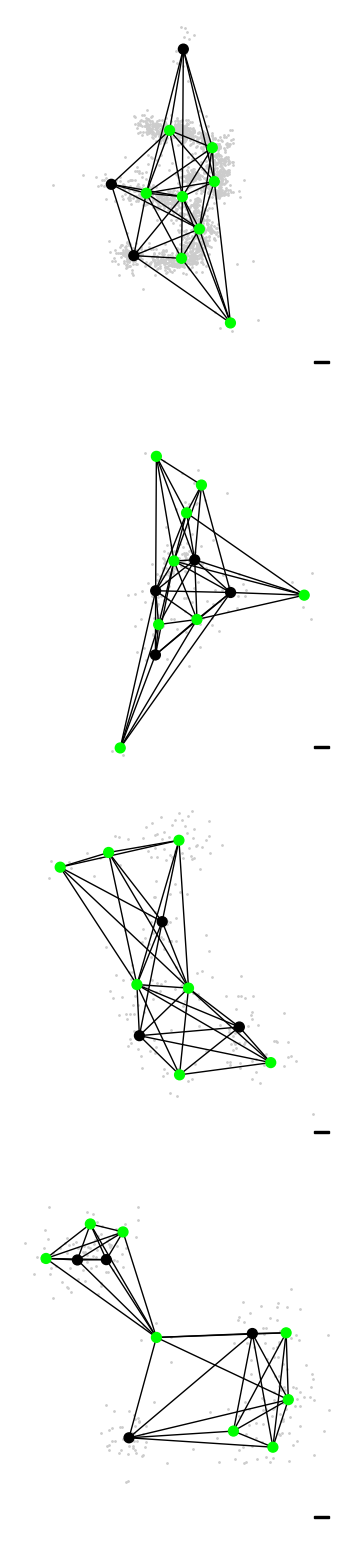

In [11]:
# visualise overlaid subgraph using matplotlib

dataitems = torch.load(os.path.join(project_directory, "output/subgraphx_dataitems_rollout_100.pt"))
node_imps = torch.load(os.path.join(project_directory, "output/subgraphx_nodeimps_rollout_100.pt"))

if not final_test:
    fold = config["fold"]
    file_folder = f"processed/fold_{fold}"
else:
    file_folder = "processed"

fig, ax = plt.subplots(4,1,figsize=(20,20), sharex=True, sharey=True)
for idx, file_name in enumerate(files):
    
    file_loc = find_graph_path(project_directory, file_name, file_folder)
    # raw file
    processed_file = torch.load(file_loc)
    processed_file = processed_file.pos_dict['locs'].cpu().numpy()
    x = processed_file[:,0]
    y = processed_file[:,1]
     # center points
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    x = x - x_mean 
    y = y - y_mean
    ax[idx].set_aspect('equal', adjustable='box')
    ax[idx].scatter(y, x, s=1, c='0.8')
    #ax[idx].axis('off')
    scalebar = AnchoredSizeBar(ax[idx].transData,
                               0.1, '', 'lower right', 
                               pad=1,
                               color='k',
                               frameon=False,
                               size_vertical=0.01)

    ax[idx].add_artist(scalebar)
    # graph
    nx_g = to_networkx(dataitems[idx], to_undirected=True)
    nx_g.remove_edges_from(nx.selfloop_edges(nx_g))
    pos = dataitems[idx].pos.cpu().numpy()
    node_color = np.where(node_imps[idx].cpu().numpy(), '#00FF00', 'k')
    # center points
    pos[:,0] = pos[:,0] - x_mean
    pos[:,1] = pos[:,1] - y_mean
    draw(nx_g, pos=np.flip(pos, axis= 1), ax=ax[idx], node_color=node_color, node_size=50)
output_path = os.path.join(project_directory, "output", "combined" + '_subgraphx_s_1.svg') 
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(output_path, transparent=True, bbox_inches="tight", pad_inches=0)
